In [2]:
import pandas as pd
import re
from konlpy.tag import Okt

# 데이터 로드
df = pd.read_csv('./data/result_review.csv')

# 감정 레이블 생성 함수
def assign_sentiment_label(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

# 감정 레이블 추가
df['sentiment'] = df['rating'].apply(assign_sentiment_label)

# 전처리 함수 정의
def preprocess_text_korean(text):
    # 한글만 남기고 다른 문자 제거
    text = re.sub(r'[^가-힣\s]', '', text)
    
    # Okt 객체 생성
    okt = Okt()
    
    # 토큰화
    tokens = okt.morphs(text)
    
    # 불용어 리스트 정의 (필요에 따라 수정)
    stop_words = set(['을', '를', '이', '가', '의', '에', '게', '한', '은', '는', '과', '와'])
    
    # 불용어 제거
    tokens = [word for word in tokens if word not in stop_words]
    
    # 토큰을 공백으로 결합
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

# 리뷰 데이터 전처리
df['cleaned_review'] = df['review'].apply(preprocess_text_korean)

# 전처리된 데이터 확인
print(df[['review', 'cleaned_review']].head())

# 전처리된 데이터 저장
df.to_csv('./data/review3_cleaned_fi.csv', index=False)


                                              review  \
0  완전 가성비 최고 대용량 토너예요! 가격도 엄청 저렴한데 용량이 어마무시해서 스킨팩...   
1  예전에 패드 너어어어무 만족해하며 썼던 기억이 떠올라서 구매해 본 토너입니다!! 아...   
2  이것민 바르고 화장한다는데 좋네요. 기존 토너보단 에멀젼 느낌이라 지성분들 이것만 ...   
3  벌써 n병째 재구매하는, 이제는 없어서는 안 될 필수템  지성인 나에게는 4계절 모...   
4  열분 이거 가성비 갑입니다 양만 믾은 것도 아니고 제품력도 좋습니다  여러번 챱챱 ...   

                                      cleaned_review  
0  완전 가성 비 최고 대 용량 토너 예요 가격 도 엄청 저렴한데 용량 어마 무시 해서...  
1  예전 패드 너 어어 어 무 만족해하며 썼던 기억 떠올라서 구매 해 본 토너 입니다 ...  
2  것민 바르고 화장 한다는데 좋네요 기존 토너 보단 에멀젼 느낌 이라 지성 분들 것 ...  
3  벌써 병 째 재구 매하 이제 없어서는 안 될 필수 템 지성인 나 에게는 계절 모두 ...  
4  열 분 거 가성 비 갑 입니다 양 만 믾 것 도 아니고 제품 력 도 좋습니다 여러 ...  


Accuracy: 0.8582089552238806

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        39
     neutral       0.21      0.02      0.04       143
    positive       0.87      0.99      0.92      1158

    accuracy                           0.86      1340
   macro avg       0.36      0.34      0.32      1340
weighted avg       0.77      0.86      0.80      1340



C:\Users\smhrd\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\smhrd\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\smhrd\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


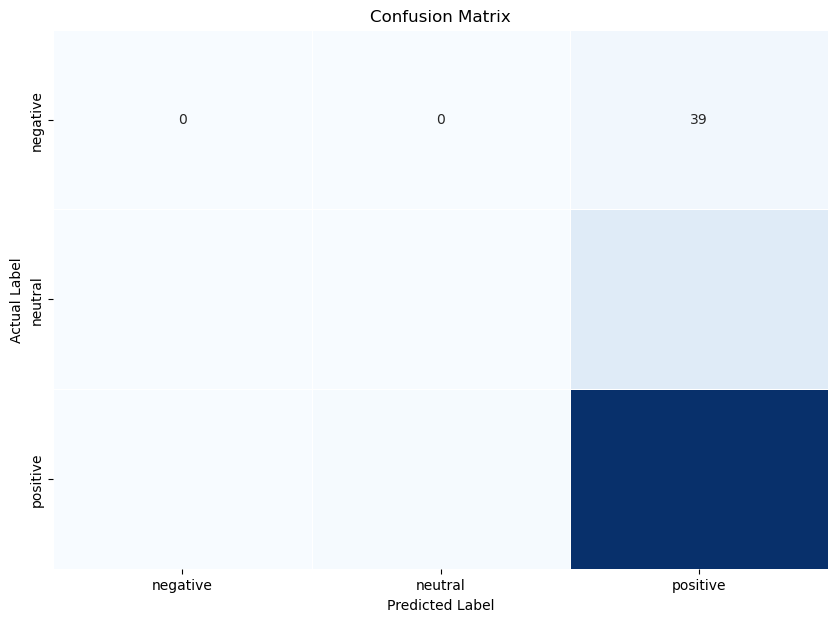

CSV 파일로 저장되었습니다.


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
df = pd.read_csv('./data/review3_cleaned_fi.csv')

# NaN 값을 빈 문자열로 대체
df['cleaned_review'].fillna('', inplace=True)

# 데이터와 레이블 분리
X = df['cleaned_review']
y = df['sentiment']

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE 오버샘플링과 RandomUnderSampler 언더샘플링을 포함한 파이프라인 설정
smote = SMOTE(random_state=42)
under_sampler = RandomUnderSampler(random_state=42)
tfidf_vectorizer = TfidfVectorizer()
rf_model = RandomForestClassifier(random_state=42)

pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('sampling', smote),
    ('classifier', rf_model)
])

# 모델 학습
pipeline.fit(X_train, y_train)

# 예측
y_pred = pipeline.predict(X_test)

# 평가
print("Accuracy:", pipeline.score(X_test, y_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 혼동 행렬 생성
cm = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])

# 혼동 행렬을 데이터프레임으로 변환
cm_df = pd.DataFrame(cm, index=['negative', 'neutral', 'positive'], columns=['negative', 'neutral', 'positive'])

# 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 각 리뷰에 대한 긍부정 점수 계산
# 모델의 확률 예측 얻기
probs = pipeline.predict_proba(X)


# 확률을 데이터프레임으로 변환
probs_df = pd.DataFrame(probs, columns=pipeline.classes_, index=df.index)

# 점수 계산 (여기서는 긍정 클래스 'positive'의 확률을 점수로 사용)
df['positive_score'] = probs_df['positive']

# 결과를 CSV 파일로 저장 (정렬하지 않음)
df.to_csv('./data/result_with_scores_final.csv', index=False)

print("CSV 파일로 저장되었습니다.")



In [4]:
# 결과 확인
df[[ 'cleaned_review', 'positive_score']]

,cleaned_review,positive_score
0,완전 가성 비 최고 대 용량 토너 예요 가격 도 엄청 저렴한데 용량 어마 무시 해서...,0.94
1,예전 패드 너 어어 어 무 만족해하며 썼던 기억 떠올라서 구매 해 본 토너 입니다 ...,0.79
2,것민 바르고 화장 한다는데 좋네요 기존 토너 보단 에멀젼 느낌 이라 지성 분들 것 ...,0.90
3,벌써 병 째 재구 매하 이제 없어서는 안 될 필수 템 지성인 나 에게는 계절 모두 ...,0.87
4,열 분 거 가성 비 갑 입니다 양 만 믾 것 도 아니고 제품 력 도 좋습니다 여러 ...,0.99
...,...,...
6695,선물 받아서 사용 했는데 너무 순해요 잘 못 쓰면 따갑고 트러블 도 많이 올라오는데...,0.77
6696,순행 클렌 징 폼 내용물 색깔 노란 끼 아주 약하게 있는 투명한 색 이에요 거의 투...,0.82
6697,순하구 촉촉해서 만족스러운 제품 입니다,0.97
6698,좋아서 통째 쓰는 중이 에요 순한게 느껴져서 놀러 온 친구 들 도 맘 편히 쓰더라구...,1.00


In [5]:
df_sorted = df.sort_values(by='positive_score', ascending=True)
df_sorted[['cos_name', 'cleaned_review', 'positive_score']]

,cos_name,cleaned_review,positive_score
2425,립밤,너무 별로 발라 도 각질 일어나고 향 도 강해서 별로 임 바세린 훨씬 나음,0.0
2865,따뚜아쥬 꾸뛰르,장점 이쁜 외관 디자인 각질 부각 덜 함 광택 돌아 볼륨 감 좋음 단점 향 지속 력...,0.0
3311,잉크 블랙 카라 AD [롱래시 컬링],학생 때 사서 썼던 제품 인데 개인 적 으로는 영 별로 였 습 니당 제 기준 페리페...,0.0
4639,미네랄라이즈 블러쉬,저 거 결혼식 할 때 웨딩 메이크업 받을 때 처음 써 봤어요 전문가 해줘서 인지 아...,0.0
1123,잉크래스팅 파운데이션 슬림핏 이엑스 [SPF30/PA++],촉촉하고 좋았습니다 하지만 커버 력 오래 가지는 않았어요,0.0
...,...,...,...
4506,슈가볼 벨벳 블러셔,브러쉬 케이스 안 들어가있어서 좋았어요 가루 날림 많음 다 못 쓰고 깨져서 버렸는데...,1.0
1204,에센셜 스킨 누더 쿠션 [SPF50+/PA+++],화장 두껍지 않고 지속 력 좋 가장 큰 장점 같아요 색상 도 이뻐요,1.0
3645,모노 아이즈 [매트],세 일 할 때 마다 얼마나 쟁 여 뒀는지 가성 비 짱 짱짱 색상 도 다양하고 좋음 ...,1.0
5909,센시비오 H2O,생각 보다 순위 낮네여 위 할거라고 생각 했는데 포인트 메컵 못 지워도 베이스 컨실...,1.0
